In [0]:
import pandas as pd
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/Incident/train.csv")
test = pd.read_csv("/content/drive/My Drive/Incident/test.csv")

In [0]:
#These columns has one is index and other two most missing values , so droped it
train = train.drop(['Unnamed: 0','problem_ID','change_request'], axis=1)
test = test.drop(['S.No','problem_ID','change_request'], axis=1)

In [0]:
#do constant value imputation(0) all varibles
for col in train.columns:
    train.loc[train[col] == '?', col] = '0'

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
for col in train.columns:
    train.loc[train[col] == '-100', col] = '0'   #-100 present in Id_caller
for col in test.columns:
    test.loc[train[col] == '-100', col] = '0'   #-100 present in Id_caller

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
#do constant value imputation(0) all varibles
for col in test.columns:
    test.loc[test[col] == '?', col] = '0'

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
train.head()

,ID,ID_status,active,count_reassign,count_opening,count_updated,ID_caller,opened_by,opened_time,Created_by,created_at,updated_by,updated_at,type_contact,location,category_ID,user_symptom,Support_group,support_incharge,Doc_knowledge,confirmation_check,impact,notify
0,INC0000045,New,True,0,0,0,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,29-02-2016 01:23,Updated by 21,29-02-2016 01:23,Phone,Location 143,Category 55,Symptom 72,Group 56,0,True,False,2 - Medium,Do Not Notify
1,INC0000045,Resolved,True,0,0,3,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,29-02-2016 01:23,Updated by 804,29-02-2016 11:29,Phone,Location 143,Category 55,Symptom 72,Group 56,0,True,False,2 - Medium,Do Not Notify
2,INC0000045,Closed,False,0,0,4,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,29-02-2016 01:23,Updated by 908,05-03-2016 12:00,Phone,Location 143,Category 55,Symptom 72,Group 56,0,True,False,2 - Medium,Do Not Notify
3,INC0000047,Active,True,1,0,1,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,29-02-2016 04:57,Updated by 21,29-02-2016 05:30,Phone,Location 165,Category 40,Symptom 471,Group 24,Resolver 31,True,False,2 - Medium,Do Not Notify
4,INC0000047,Active,True,1,0,2,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,29-02-2016 04:57,Updated by 21,29-02-2016 05:33,Phone,Location 165,Category 40,Symptom 471,Group 24,Resolver 31,True,False,2 - Medium,Do Not Notify


In [0]:
test

,ID,ID_status,active,count_reassign,count_opening,count_updated,ID_caller,opened_by,opened_time,Created_by,created_at,updated_by,updated_at,type_contact,location,category_ID,user_symptom,Support_group,support_incharge,Doc_knowledge,confirmation_check,notify
0,INC0000045,Resolved,True,0,0,2,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,29-02-2016 01:23,Updated by 642,29-02-2016 08:53,Phone,Location 143,Category 55,Symptom 72,Group 56,0,True,False,Do Not Notify
1,INC0000047,New,True,0,0,0,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,29-02-2016 04:57,Updated by 746,29-02-2016 04:57,Phone,Location 165,Category 40,Symptom 471,Group 70,Resolver 89,True,False,Do Not Notify
2,INC0000047,Active,True,1,0,3,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,29-02-2016 04:57,Updated by 804,29-02-2016 11:31,Phone,Location 165,Category 40,Symptom 471,Group 24,Resolver 31,True,False,Do Not Notify
3,INC0000047,Resolved,True,1,0,7,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,29-02-2016 04:57,Updated by 332,01-03-2016 09:52,Phone,Location 165,Category 40,Symptom 471,Group 24,Resolver 89,True,False,Do Not Notify
4,INC0000057,New,True,0,0,4,Caller 4416,Opened by 8,29-02-2016 06:10,0,0,Updated by 21,01-03-2016 02:54,Phone,Location 204,Category 20,Symptom 471,Group 70,0,True,False,Do Not Notify
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42509,INC0119457,Closed,False,0,0,1,Caller 2403,Opened by 508,13-02-2017 11:31,0,0,Updated by 931,13-02-2017 11:31,IVR,Location 246,Category 50,Symptom 533,Group 70,0,False,False,Do Not Notify
42510,INC0119983,New,True,0,0,0,Caller 831,Opened by 508,14-02-2017 11:11,0,0,Updated by 908,14-02-2017 11:11,IVR,Location 246,Category 50,Symptom 533,Group 70,0,False,False,Do Not Notify
42511,INC0120303,New,True,0,0,0,Caller 1866,Opened by 508,15-02-2017 01:52,0,0,Updated by 908,15-02-2017 01:52,IVR,Location 246,Category 50,Symptom 533,Group 70,0,False,False,Do Not Notify
42512,INC0120319,New,True,0,0,0,Caller 1899,Opened by 508,15-02-2017 07:09,0,0,Updated by 908,15-02-2017 07:09,IVR,Location 246,Category 50,Symptom 533,Group 70,0,False,False,Do Not Notify


               Columns  uniques
0                   ID    24569
1            ID_status        9
2               active        2
3       count_reassign       28
4        count_opening        9
5        count_updated      113
6            ID_caller     5223
7            opened_by      208
8          opened_time    19620
9           Created_by      186
10          created_at    11485
11          updated_by      751
12          updated_at    43003
13        type_contact        5
14            location      225
15         category_ID       57
16        user_symptom      516
17       Support_group       78
18    support_incharge      232
19       Doc_knowledge        2
20  confirmation_check        2
21              impact        3
22              notify        2


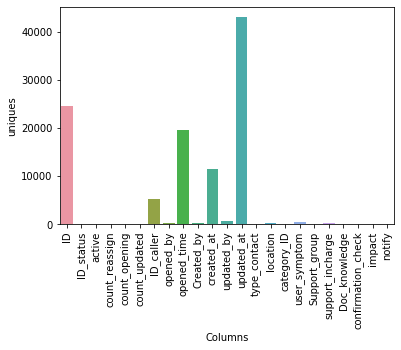

In [0]:
#Check the unique values
import seaborn as sns
nu = train.nunique().reset_index()
nu.columns = ['Columns', 'uniques']
ax = sns.barplot(x='Columns', y='uniques', data=nu)
ax.tick_params(axis='x', rotation=90)
print(nu)

In [0]:
import datetime
train.created_at.replace(to_replace =["0"],value ="31-01-2016 00:00", inplace= True)  #contant datevalue
test.created_at.replace(to_replace =["0"],value ="31-01-2016 00:00", inplace= True)   #contant date value

In [0]:
print("train \n",train.created_at.value_counts() , "\ntest\n ",test.created_at.value_counts())

train 
 31-01-2016 00:00    37174
04-07-2016 14:50       41
15-03-2016 15:19       38
19-04-2016 11:32       36
30-03-2016 08:23       33
                    ...  
03-05-2016 09:48        1
04-04-2016 08:22        1
24-03-2016 11:30        1
13-05-2016 05:08        1
20-04-2016 17:06        1
Name: created_at, Length: 11485, dtype: int64 
test
  31-01-2016 00:00    15902
17-03-2016 17:56       18
29-03-2016 14:39       15
04-03-2016 10:31       15
04-07-2016 14:50       15
                    ...  
05-05-2016 11:03        1
02-03-2016 18:21        1
30-05-2016 09:04        1
25-04-2016 17:03        1
01-03-2016 08:04        1
Name: created_at, Length: 10005, dtype: int64


In [0]:
#Data preprocessing for opened_time , created_at , updated_at	these datetime columns
#we converting into day wies ordinal encoding
#For e.g: 
"""
07-03-2016 11:04    43                                7
07-03-2016 09:25    39                                7
07-03-2016 09:11    38                                7
30-03-2016 09:20    37                                30
30-03-2016 08:20    36                                30
Name: opened_time, dtype: int64

07-03-2016 11:04 same date but timing should be different sso we did day ordinal encoding of those columns (its healps to reducing levels)
"""
train['opened_time']= pd.to_datetime(train['opened_time']) 
train['created_at']= pd.to_datetime(train['created_at']) 
train['updated_at']= pd.to_datetime(train['updated_at']) 
test['opened_time']= pd.to_datetime(test['opened_time']) 
test['created_at']= pd.to_datetime(test['created_at']) 
test['updated_at']= pd.to_datetime(test['updated_at']) 


In [0]:
#opened_time , created_at , updated_at
train['opened_time_d'] = train['opened_time'].dt.day
train['created_at_d'] = train['created_at'].dt.day
train['updated_at_d'] = train['updated_at'].dt.day
test['opened_time_d'] = test['opened_time'].dt.day
test['created_at_d'] = test['created_at'].dt.day
test['updated_at_d'] = test['updated_at'].dt.day

In [0]:
train = train.drop(["opened_time" , "created_at" , "updated_at"], axis=1)
test = test.drop(["opened_time" , "created_at" , "updated_at"], axis=1)

KeyError: ignored

In [0]:
print("Train Dataset \n",train.info(),"\nTest Datset : \n",test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99198 entries, 0 to 99197
Data columns (total 23 columns):
ID                    99198 non-null object
ID_status             99198 non-null object
active                99198 non-null bool
count_reassign        99198 non-null int64
count_opening         99198 non-null int64
count_updated         99198 non-null int64
ID_caller             99198 non-null object
opened_by             99198 non-null object
Created_by            99198 non-null object
updated_by            99198 non-null object
type_contact          99198 non-null object
location              99198 non-null object
category_ID           99198 non-null object
user_symptom          99198 non-null object
Support_group         99198 non-null object
support_incharge      99198 non-null object
Doc_knowledge         99198 non-null bool
confirmation_check    99198 non-null bool
impact                99198 non-null object
notify                99198 non-null object
opened_time_d       

In [0]:
#Label encoding Train and Test dataset
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['ID'] = le.fit_transform(train['ID'])
train['ID_status'] = le.fit_transform(train['ID_status'])
train['active'] = le.fit_transform(train['active'])
train['ID_caller'] = le.fit_transform(train['ID_caller'])
train['opened_by'] = le.fit_transform(train['opened_by'])
train['Created_by'] = le.fit_transform(train['Created_by'])
train['updated_by'] = le.fit_transform(train['updated_by'])
train['type_contact'] = le.fit_transform(train['type_contact'])
train['location'] = le.fit_transform(train['location'])
train['category_ID'] = le.fit_transform(train['category_ID'])
train['user_symptom'] = le.fit_transform(train['user_symptom'])
train['Support_group'] = le.fit_transform(train['Support_group'])
train['support_incharge'] = le.fit_transform(train['support_incharge'])
train['Doc_knowledge'] = le.fit_transform(train['Doc_knowledge'])
train['confirmation_check'] = le.fit_transform(train['confirmation_check'])
train['impact'] = le.fit_transform(train['impact'])
train['notify'] = le.fit_transform(train['notify'])
#train['problem_ID'] = le.fit_transform(train['problem_ID'])
#train['change_request'] = le.fit_transform(train['change_request'])

In [0]:
test['ID'] = le.fit_transform(test['ID'])
test['ID_status'] = le.fit_transform(test['ID_status'])
test['active'] = le.fit_transform(test['active'])
test['ID_caller'] = le.fit_transform(test['ID_caller'])
test['opened_by'] = le.fit_transform(test['opened_by'])
test['Created_by'] = le.fit_transform(test['Created_by'])
test['updated_by'] = le.fit_transform(test['updated_by'])
test['type_contact'] = le.fit_transform(test['type_contact'])
test['location'] = le.fit_transform(test['location'])
test['category_ID'] = le.fit_transform(test['category_ID'])
test['user_symptom'] = le.fit_transform(test['user_symptom'])
test['Support_group'] = le.fit_transform(test['Support_group'])
test['support_incharge'] = le.fit_transform(test['support_incharge'])
test['Doc_knowledge'] = le.fit_transform(test['Doc_knowledge'])
test['confirmation_check'] = le.fit_transform(test['confirmation_check'])
test['notify'] = le.fit_transform(test['notify'])
#test['problem_ID'] = le.fit_transform(test['problem_ID'])
#test['change_request'] = le.fit_transform(test['change_request'])

In [0]:
#train.to_csv('/content/drive/My Drive/Incident/NewTrain.csv')
#test.to_csv('/content/drive/My Drive/Incident/NewTest.csv')

# **Univariate Selection**

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

The example below uses the chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Mobile Price Range Prediction Dataset.

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [0]:
y = train['impact']
X = train.drop(['impact'], axis = 1)

In [0]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X,y)

In [0]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [0]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [0]:
featureScores

,Specs,Score
0,ID,1.768104e+06
1,ID_status,3.928703e+00
2,active,1.168790e+01
3,count_reassign,1.677602e+02
4,count_opening,3.839474e+01
5,count_updated,1.222077e+03
6,ID_caller,2.265937e+03
7,opened_by,3.078620e+04
8,Created_by,3.923304e+04
9,updated_by,7.767713e+03


In [0]:
#Select Top 20
print(featureScores.nlargest(20,'Score'))  #drop ID_status , type_contact
train.columns

                 Specs         Score
0                   ID  1.768104e+06
8           Created_by  3.923304e+04
7            opened_by  3.078620e+04
13        user_symptom  9.649329e+03
9           updated_by  7.767713e+03
15    support_incharge  7.280527e+03
6            ID_caller  2.265937e+03
5        count_updated  1.222077e+03
14       Support_group  1.207697e+03
19       opened_time_d  9.264918e+02
20        created_at_d  8.327640e+02
16       Doc_knowledge  7.261787e+02
21        updated_at_d  5.022731e+02
11            location  2.617487e+02
3       count_reassign  1.677602e+02
17  confirmation_check  9.078740e+01
12         category_ID  5.038379e+01
4        count_opening  3.839474e+01
2               active  1.168790e+01
18              notify  4.667886e+00


Index(['ID', 'ID_status', 'active', 'count_reassign', 'count_opening',
       'count_updated', 'ID_caller', 'opened_by', 'Created_by', 'updated_by',
       'type_contact', 'location', 'category_ID', 'user_symptom',
       'Support_group', 'support_incharge', 'Doc_knowledge',
       'confirmation_check', 'impact', 'notify', 'opened_time_d',
       'created_at_d', 'updated_at_d'],
      dtype='object')


# **Feature Importance**

You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

In [0]:
from sklearn.ensemble import  ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

SyntaxError: ignored

In [0]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

NameError: ignored

In [0]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# **Correlation Matrix with Heatmap**

Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

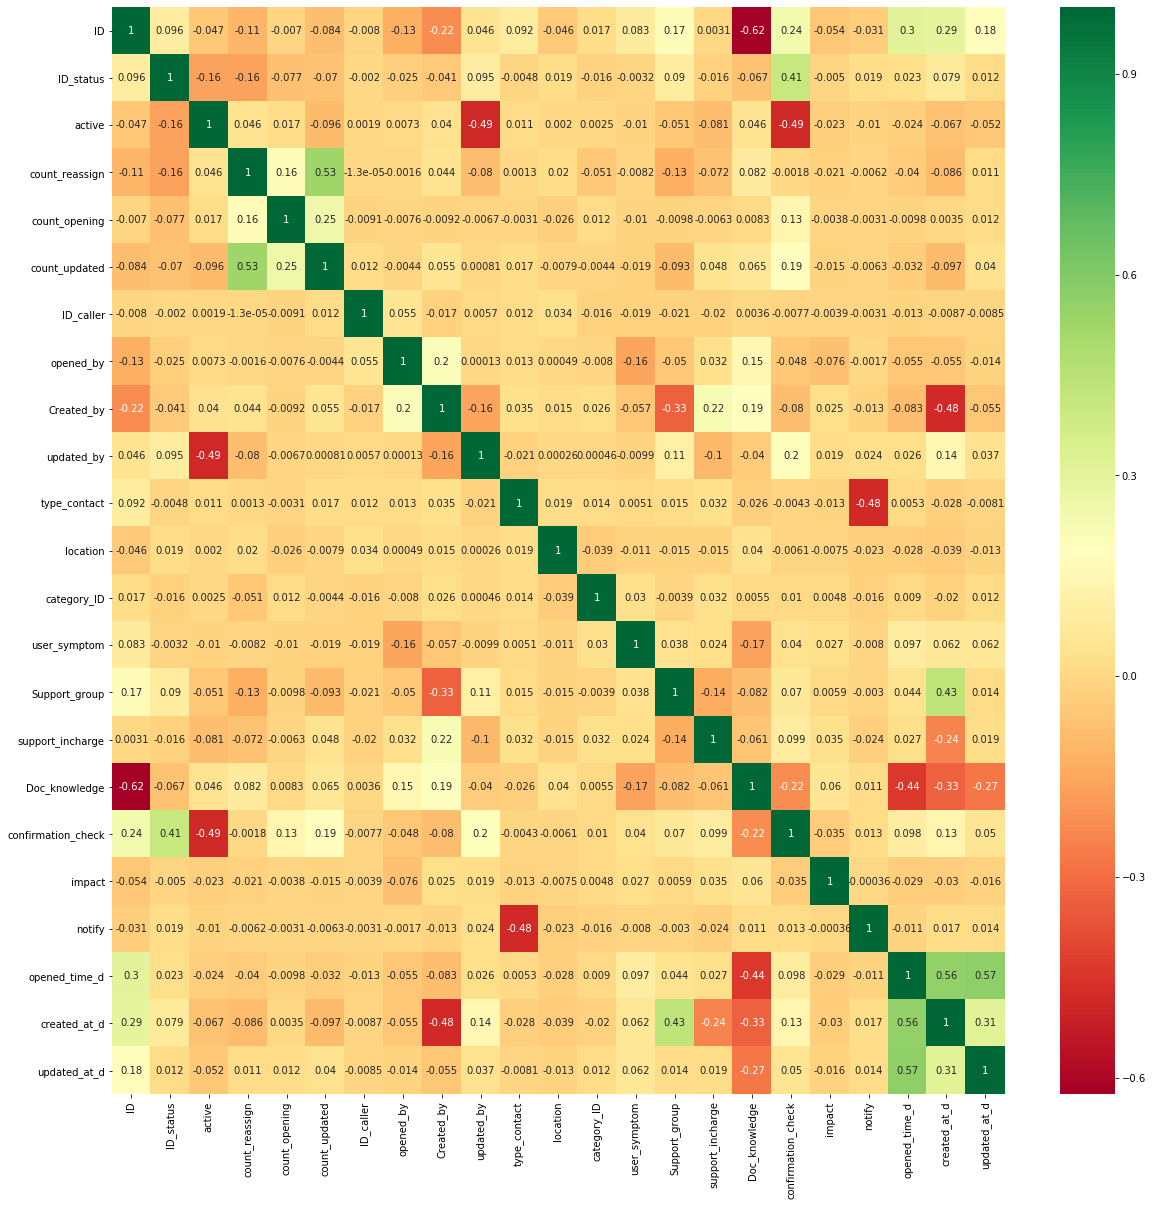

In [0]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
train=train.drop(['ID_status' , 'type_contact'],axis=1)
test=test.drop(['ID_status' , 'type_contact'],axis=1)

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit as sss
split = sss(n_splits = 5, test_size = 0.2 , random_state = 42)
for train_index , test_index in split.split(train, train['impact']):
    train_x = train.loc[train_index]
    train_y = train.loc[test_index]

In [0]:
y = train_x['impact']
X = train_x.drop(['impact'], axis = 1)

y_t = train_y['impact']
X_t = train_y.drop(['impact'], axis = 1)

,ID,active,count_reassign,count_opening,count_updated,ID_caller,opened_by,Created_by,updated_by,location,category_ID,user_symptom,Support_group,support_incharge,Doc_knowledge,confirmation_check,notify,opened_time_d,created_at_d,updated_at_d
25628,5172,1,3,0,13,4223,15,155,612,218,14,358,14,120,0,0,0,17,17,23
47436,10614,1,0,0,0,2380,189,125,26,222,43,0,0,167,0,0,0,4,4,4
93067,22961,1,0,0,1,1337,32,0,286,44,13,328,11,0,0,0,0,24,31,24
67131,15870,0,1,0,6,3609,123,86,681,44,16,358,19,211,0,1,0,27,27,5
69112,16436,1,0,0,0,1327,5,0,681,222,34,358,41,0,0,0,0,28,31,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,1331,1,7,0,38,4935,0,179,121,218,24,0,14,203,1,1,0,3,3,31
72056,17257,1,1,0,2,4916,5,144,286,60,47,185,15,221,0,0,0,5,5,5
94308,23288,1,0,0,1,251,32,0,511,105,36,0,58,78,0,0,0,25,31,25
95722,23685,1,0,0,2,3251,32,2,303,105,43,358,16,28,0,1,0,30,30,6


In [0]:
from sklearn.neighbors import KNeighborsClassifier as KNC
acc= []
for i in range(1,21,2):
    neigh = KNC(n_neighbors = i)
    neigh.fit(X,y)
    train_acc = np.mean(neigh.predict(X) == y)
    test_acc = np.mean(neigh.predict(X_t) == y_t)
    acc.append([train_acc, test_acc])

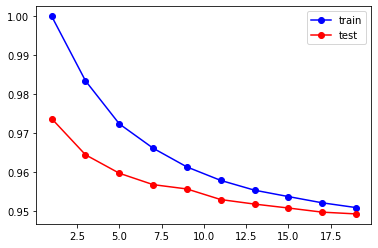

In [0]:
plt.plot(np.arange(1,21,2),[i[0] for i in acc], "bo-")
plt.plot(np.arange(1,21,2), [i[1] for i in acc], "ro-")
plt.legend(["train","test"])

In [0]:
near15 = KNC(n_neighbors = 15)
near15.fit(X, y)
train_acc15 = np.mean(near15.predict(X) == y)
train_acc15   #0.9533

0.953741273721616

In [0]:
test_acc15 = np.mean(near15.predict(X_t)== y_t)
test_acc15  #0.9510

0.9508064516129032

In [0]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score , f1_score  , classification_report , accuracy_score
pred = near15.predict(X_t)
print(confusion_matrix(pred, y_t))
print(classification_report(pred, y_t))

[[   47    35     1]
 [  442 18724   450]
 [    0    48    93]]
              precision    recall  f1-score   support

           0       0.10      0.57      0.16        83
           1       1.00      0.95      0.97     19616
           2       0.17      0.66      0.27       141

    accuracy                           0.95     19840
   macro avg       0.42      0.73      0.47     19840
weighted avg       0.99      0.95      0.97     19840



In [0]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(n_jobs = 2, oob_score=True , n_estimators = 100, criterion = 'entropy')
RFmodel.fit(X , y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
X_t['pred'] = RFmodel.predict(X_t)
from sklearn.metrics import confusion_matrix, recall_score, precision_score , f1_score  , classification_report , accuracy_score
confusion_matrix(y_t , X_t['pred'])

array([[  275,   214,     0],
       [   13, 18771,    23],
       [    1,   122,   421]])

In [0]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_t , X_t['pred'])
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))  #0.981

In [0]:
print(confusion_matrix(y_t , X_t['pred']))
print(classification_report(y_t , X_t['pred']))  #98

[[  275   214     0]
 [   13 18771    23]
 [    1   122   421]]
              precision    recall  f1-score   support

           0       0.95      0.56      0.71       489
           1       0.98      1.00      0.99     18807
           2       0.95      0.77      0.85       544

    accuracy                           0.98     19840
   macro avg       0.96      0.78      0.85     19840
weighted avg       0.98      0.98      0.98     19840



In [0]:
# Fitting XGBoost to the Training set
import xgboost
classifier = xgboost.XGBClassifier()
classifier.fit(X, y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Predicting the Test set results
y_pred = classifier.predict(X_t)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_t, y_pred)
cm

array([[    8,   478,     3],
       [    0, 18784,    23],
       [    0,   461,    83]])

In [0]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score , f1_score  , classification_report , accuracy_score
print(confusion_matrix(y_t , y_pred))
print(classification_report(y_t , y_pred))
print(accuracy_score(y_t , y_pred))  #0.9521

[[    8   478     3]
 [    0 18784    23]
 [    0   461    83]]
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       489
           1       0.95      1.00      0.98     18807
           2       0.76      0.15      0.25       544

    accuracy                           0.95     19840
   macro avg       0.90      0.39      0.42     19840
weighted avg       0.95      0.95      0.93     19840

0.9513608870967742


In [0]:
#select RF and build with Trian dataset
y = train['impact']
X = train.drop(['impact'], axis = 1)

from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(n_jobs = 2, oob_score=True , n_estimators = 100, criterion = 'entropy')
RFmodel.fit(X , y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
pred = RFmodel.predict(test)
pred = pd.DataFrame(pred)

In [0]:
sub_df=pd.read_csv('/content/drive/My Drive/Incident/Sample Submission.csv')
sub_df

,ID,prediction1
0,1,2 - Medium
1,2,2 - Medium
2,3,2 - Medium
3,4,2 - Medium
4,5,2 - Medium
...,...,...
42509,42510,3 - Low
42510,42511,3 - Low
42511,42512,3 - Low
42512,42513,3 - Low


In [0]:
datasets=pd.concat([sub_df['ID'],pred],axis=1)

In [0]:
datasets.columns=['Id','prediction1']
prediction2 = { 1:'2 - Medium',
                2:'3 - Low',
                3:'1 - High',
}
datasets['prediction1'] = datasets.prediction1.map(prediction2)
datasets.to_csv('/content/drive/My Drive/Incident/sample_RF.csv',index=False)      #---score= 0.9526

In [0]:
datasets

,Id,prediction1
0,1,2 - Medium
1,2,2 - Medium
2,3,2 - Medium
3,4,2 - Medium
4,5,2 - Medium
...,...,...
42509,42510,2 - Medium
42510,42511,2 - Medium
42511,42512,2 - Medium
42512,42513,2 - Medium


In [0]:
datasets.prediction1.value_counts()


2 - Medium    42261
3 - Low         190
Name: prediction1, dtype: int64